In [ ]:
import os
import torch
import torchaudio
import torch.nn as nn
from torchaudio.datasets import SPEECHCOMMANDS
import matplotlib.pyplot as plt
import IPython.display as ipd

Download the Dataset
---------------------

All the datasets are subclasses of torch.utils.data.Datasets and SPEECHCOMMANDS is a version of the Google's dataset. All audio files are one second long, each of them sampled at 16kHz and mono (1 channel).

[Source code: https://pytorch.org/audio/stable/_modules/torchaudio/datasets/speechcommands.html ]

In [ ]:
class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.join(self._path, line.strip()) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training, validation and testing split of the data. 
train_dataset = SubsetSC("training")
test_dataset = SubsetSC("testing")
validation_dataset = SubsetSC("validation")

  0%|          | 0.00/2.26G [00:00<?, ?B/s]

Analysis of Speech Commands dataset
------------------------



In [ ]:
# Check number of audio files
num_train = len(train_dataset)
num_val = len(validation_dataset)
num_test = len(test_dataset)
print("Total audio files: " + str(num_train + num_val + num_test))
print("Audio files in training: " + str(num_train))
print("Audio files in validation: " + str(num_val))
print("Audio files in test: " + str(num_test))
print("")

Total audio files: 126815
Audio files in training: 105829
Audio files in validation: 9981
Audio files in test: 11005



In [ ]:
# Check number of speakers
train_speakers = len(list(set(speaker[3] for speaker in train_dataset)))
val_speakers = len(list(set(speaker[3] for speaker in validation_dataset)))
test_speakers = len(list(set(speaker[3] for speaker in test_dataset)))

print("Total speakers: " + str(train_speakers + val_speakers + test_speakers))
print("Speakers in training: " + str(train_speakers))
print("Speakers in validation: " + str(val_speakers))
print("Speakers in testing: " + str(test_speakers))

Total speakers: 3124
Speakers in training: 2618
Speakers in validation: 256
Speakers in testing: 250


# Labels
Commands said by speakers.

In [ ]:
labels = sorted(list(set(label[2] for label in train_dataset)))
print("Number of labels: " + str(len(labels)))
print(labels)

Number of labels: 35
['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


# Data exploration

In [ ]:
# Tuple made of a waveform (audio signal), sample rate, utterance (label), ID of the speaker, 
# number of the utterance.
waveform, sample_rate, label, speaker_id, utterance_number = train_dataset[-1] # Last audio of training

print(waveform)

print(label)
ipd.Audio(waveform.numpy(), rate=sample_rate)

tensor([[-0.0010, -0.0009, -0.0012,  ..., -0.0006, -0.0013, -0.0009]])
zero


Shape: torch.Size([1, 16000])
Sample rate: 16000


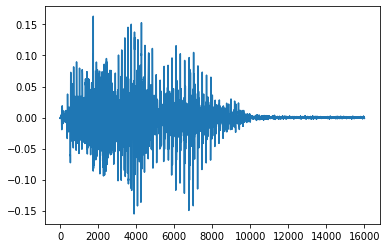

In [ ]:
print("Shape: {}".format(waveform.size()))
print("Sample rate: {}".format(sample_rate))

plt.plot(waveform.t().numpy())

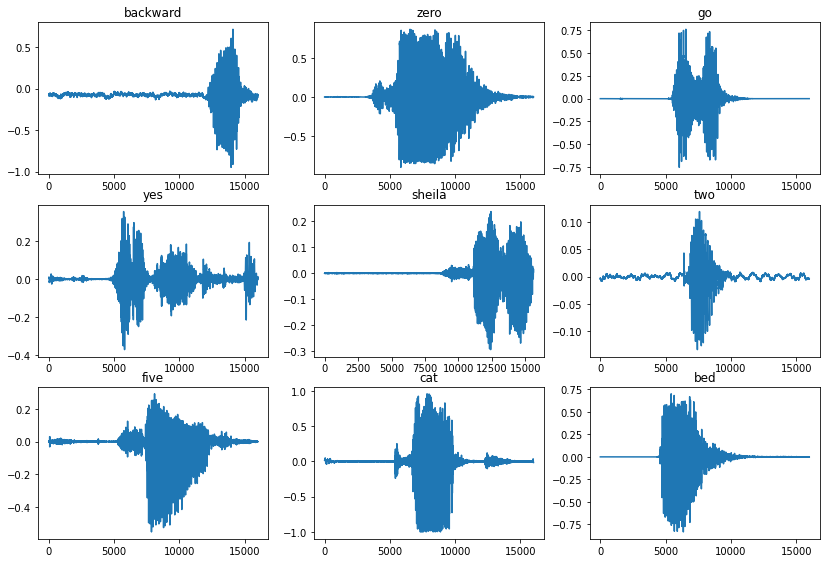

In [ ]:
rows = 3 
cols = 3 
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(14,9.5))

train_example = []
train_example.append(train_dataset[0])
train_example.append(train_dataset[104201])
train_example.append(train_dataset[31002])
train_example.append(train_dataset[100071])
train_example.append(train_dataset[72100])
train_example.append(train_dataset[86710])
train_example.append(train_dataset[19671])
train_example.append(train_dataset[7671])
train_example.append(train_dataset[3671])

for count, audio in enumerate(train_example):
  r = count // cols
  c = count % cols
  ax = axes[r][c]
  ax.plot(audio[0].t().numpy())
  label = str(audio[2])
  ax.set_title(label)
plt.show()

# Transform raw data into Mel Spectogram
A spectogram is a visualization of the frequency spectrum of a signal and the Mel scale mimics how the human ear works (humans are better at detecting differences at lower frequencies than at higher frequencies). We use torchaudio library to get the mel spectogram.

Shape of spectrogram: torch.Size([1, 80, 81])


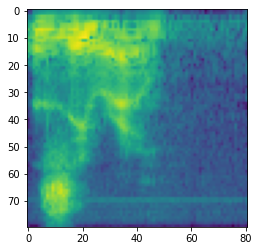

In [ ]:
mel_spectogram = torchaudio.transforms.MelSpectrogram(n_mels=80)(waveform)
print("Shape of spectrogram: {}".format(mel_spectogram.size()))

plt.figure()
p = plt.imshow(mel_spectogram.log2()[0,:,:].detach().numpy())